## Importing all necessary libraires

In [2]:
import pandas as pd
import numpy as np
import json
# plotting
import os
import pathlib
import warnings
from joblib import load
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mplsoccer import Pitch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import joblib
from sklearn.feature_selection import f_regression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_selection import f_classif
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

## Loading the Data in json format to a Dataframe

In [4]:
#load JSON file
england_data = pd.read_json('events_England.json')
#england_data = all_data.loc[all_data['teamId']==1625]
england_data
england_data.columns

Index(['eventId', 'subEventName', 'tags', 'playerId', 'positions', 'matchId',
       'eventName', 'teamId', 'matchPeriod', 'eventSec', 'subEventId', 'id'],
      dtype='object')

## Checking columns in eventName and subEventName

In [6]:
X=england_data['eventName'].unique()
Y=england_data['subEventName'].unique()
print(X,Y)

['Pass' 'Duel' 'Foul' 'Free Kick' 'Shot' 'Save attempt'
 'Others on the ball' 'Interruption' 'Goalkeeper leaving line' 'Offside'] ['Simple pass' 'High pass' 'Head pass' 'Air duel' 'Ground loose ball duel'
 'Smart pass' 'Launch' 'Ground defending duel' 'Ground attacking duel'
 'Foul' 'Free Kick' 'Cross' 'Shot' 'Reflexes' 'Touch' 'Clearance'
 'Ball out of the field' 'Throw in' 'Goal kick' 'Corner'
 'Goalkeeper leaving line' 'Hand pass' 'Acceleration' 'Save attempt' ''
 'Free kick cross' 'Free kick shot' 'Hand foul' 'Violent Foul' 'Protest'
 'Whistle' 'Late card foul' 'Out of game foul' 'Penalty' 'Time lost foul'
 'Simulation']


## Dropping unwanted subeventName's and evenName's

In [8]:
interrupt_england = england_data.loc[england_data['eventName'] == 'Interruption']
england_data = england_data.drop(interrupt_england.index)

#filtering out Duels
Duels = england_data.loc[england_data['eventName'] == 'Duel']
england_data = england_data.drop(Duels.index)

#filtering the subevents not needed
sevents_dropped = england_data.loc[england_data["subEventName"].isin(["Ball out of the field","Save attempt","Goalkeeper leaving line","Reflexes","Launch","Hand pass"])]
england_data_new = england_data.drop(sevents_dropped.index)


## Filtering the dataset with only passes and the tag id should be accurate

In [10]:
england_data_update = england_data_new[(england_data_new["eventName"] == "Pass")]
england_data_filtered = england_data_update.loc[england_data_update.apply(lambda row : {'id': 1801} in row.tags,axis=1)]
england_data_filtered

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175
...,...,...,...,...,...,...,...,...,...,...,...,...
643133,8,Simple pass,[{'id': 1801}],37725,"[{'y': 56, 'x': 57}, {'y': 63, 'x': 65}]",2500098,Pass,1633,2H,2758.973892,85,251596217
643134,8,Simple pass,[{'id': 1801}],8313,"[{'y': 63, 'x': 65}, {'y': 96, 'x': 61}]",2500098,Pass,1633,2H,2760.286946,85,251596219
643135,8,Simple pass,[{'id': 1801}],379209,"[{'y': 96, 'x': 61}, {'y': 85, 'x': 40}]",2500098,Pass,1633,2H,2763.698599,85,251596221
643141,8,Simple pass,[{'id': 1801}],8561,"[{'y': 70, 'x': 59}, {'y': 89, 'x': 53}]",2500098,Pass,1633,2H,2783.137836,85,251596225


## Add new column as interception and find if it was intercepted or not by tag id

In [12]:
england_data_filtered["interception"] = england_data_filtered['tags'].apply(lambda x : 1 if {'id' : 1401} in x else 0)
#england_data_filtered.loc[england_data_filtered["interception"] == 0]

In [13]:
england_data_filtered

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,interception
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,0
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,0
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,0
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,0
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
643133,8,Simple pass,[{'id': 1801}],37725,"[{'y': 56, 'x': 57}, {'y': 63, 'x': 65}]",2500098,Pass,1633,2H,2758.973892,85,251596217,0
643134,8,Simple pass,[{'id': 1801}],8313,"[{'y': 63, 'x': 65}, {'y': 96, 'x': 61}]",2500098,Pass,1633,2H,2760.286946,85,251596219,0
643135,8,Simple pass,[{'id': 1801}],379209,"[{'y': 96, 'x': 61}, {'y': 85, 'x': 40}]",2500098,Pass,1633,2H,2763.698599,85,251596221,0
643141,8,Simple pass,[{'id': 1801}],8561,"[{'y': 70, 'x': 59}, {'y': 89, 'x': 53}]",2500098,Pass,1633,2H,2783.137836,85,251596225,0


## Calculating the Pass Distance

In [15]:
england_data_filtered["start_x"] = england_data_filtered['positions'].apply(lambda row : row[0]['x']*105/100)
england_data_filtered["start_y"] = england_data_filtered['positions'].apply(lambda row : row[0]['x']*68/100)
england_data_filtered["end_x"] = england_data_filtered['positions'].apply(lambda row : row[1]['x']*105/100)
england_data_filtered["end_y"] = england_data_filtered['positions'].apply(lambda row : row[1]['y']*68/100)
england_data_filtered["pass_distance"] = np.sqrt((england_data_filtered["end_x"] - england_data_filtered["start_x"]) ** 2 + (england_data_filtered["end_y"] - england_data_filtered["start_y"]) ** 2)
england_data_filtered


,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,interception,start_x,start_y,end_x,end_y,pass_distance
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,0,51.45,33.32,32.55,53.04,27.314619
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,0,32.55,21.08,53.55,51.00,36.554157
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,0,53.55,34.68,36.75,48.28,21.614810
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,0,36.75,23.80,43.05,64.60,41.283532
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,0,43.05,27.88,75.60,59.84,45.617366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643133,8,Simple pass,[{'id': 1801}],37725,"[{'y': 56, 'x': 57}, {'y': 63, 'x': 65}]",2500098,Pass,1633,2H,2758.973892,85,251596217,0,59.85,38.76,68.25,42.84,9.338437
643134,8,Simple pass,[{'id': 1801}],8313,"[{'y': 63, 'x': 65}, {'y': 96, 'x': 61}]",2500098,Pass,1633,2H,2760.286946,85,251596219,0,68.25,44.20,64.05,65.28,21.494334
643135,8,Simple pass,[{'id': 1801}],379209,"[{'y': 96, 'x': 61}, {'y': 85, 'x': 40}]",2500098,Pass,1633,2H,2763.698599,85,251596221,0,64.05,41.48,42.00,57.80,27.432552
643141,8,Simple pass,[{'id': 1801}],8561,"[{'y': 70, 'x': 59}, {'y': 89, 'x': 53}]",2500098,Pass,1633,2H,2783.137836,85,251596225,0,61.95,40.12,55.65,60.52,21.350644


## Calculating the Pass Angle

In [17]:
england_data_filtered["delta_x"] = england_data_filtered["end_x"] - england_data_filtered["start_x"]
england_data_filtered["delta_y"] = england_data_filtered["end_y"] - england_data_filtered["start_y"]
england_data_filtered["pass_angle"] = np.arctan2(england_data_filtered["delta_y"],england_data_filtered["delta_x"])
england_data_filtered

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,...,id,interception,start_x,start_y,end_x,end_y,pass_distance,delta_x,delta_y,pass_angle
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,...,177959171,0,51.45,33.32,32.55,53.04,27.314619,-18.90,19.72,2.334965
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,...,177959172,0,32.55,21.08,53.55,51.00,36.554157,21.00,29.92,0.958815
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,...,177959173,0,53.55,34.68,36.75,48.28,21.614810,-16.80,13.60,2.461071
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,...,177959174,0,36.75,23.80,43.05,64.60,41.283532,6.30,40.80,1.417595
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,...,177959175,0,43.05,27.88,75.60,59.84,45.617366,32.55,31.96,0.776253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643133,8,Simple pass,[{'id': 1801}],37725,"[{'y': 56, 'x': 57}, {'y': 63, 'x': 65}]",2500098,Pass,1633,2H,2758.973892,...,251596217,0,59.85,38.76,68.25,42.84,9.338437,8.40,4.08,0.452154
643134,8,Simple pass,[{'id': 1801}],8313,"[{'y': 63, 'x': 65}, {'y': 96, 'x': 61}]",2500098,Pass,1633,2H,2760.286946,...,251596219,0,68.25,44.20,64.05,65.28,21.494334,-4.20,21.08,1.767462
643135,8,Simple pass,[{'id': 1801}],379209,"[{'y': 96, 'x': 61}, {'y': 85, 'x': 40}]",2500098,Pass,1633,2H,2763.698599,...,251596221,0,64.05,41.48,42.00,57.80,27.432552,-22.05,16.32,2.504434
643141,8,Simple pass,[{'id': 1801}],8561,"[{'y': 70, 'x': 59}, {'y': 89, 'x': 53}]",2500098,Pass,1633,2H,2783.137836,...,251596225,0,61.95,40.12,55.65,60.52,21.350644,-6.30,20.40,1.870328


## Checking for accurate interception was in which zones

In [19]:
def zones(interception , start_x):
    if interception == 1:
        if start_x <= 35.0:
            return 'defensive third'
        elif start_x > 35.0 and start_x <= 70.0 :
            return 'middle third'
        else:
            return 'offensive third'
    else:
        return 'no interception'

# Apply the function to the 'start_x' column
england_data_filtered["interception_Zones"] = england_data_filtered.apply(lambda x: zones(x.interception , x.start_x) , axis=1)
england_data_filtered
                                              
      

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,...,interception,start_x,start_y,end_x,end_y,pass_distance,delta_x,delta_y,pass_angle,interception_Zones
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,...,0,51.45,33.32,32.55,53.04,27.314619,-18.90,19.72,2.334965,no interception
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,...,0,32.55,21.08,53.55,51.00,36.554157,21.00,29.92,0.958815,no interception
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,...,0,53.55,34.68,36.75,48.28,21.614810,-16.80,13.60,2.461071,no interception
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,...,0,36.75,23.80,43.05,64.60,41.283532,6.30,40.80,1.417595,no interception
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,...,0,43.05,27.88,75.60,59.84,45.617366,32.55,31.96,0.776253,no interception
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643133,8,Simple pass,[{'id': 1801}],37725,"[{'y': 56, 'x': 57}, {'y': 63, 'x': 65}]",2500098,Pass,1633,2H,2758.973892,...,0,59.85,38.76,68.25,42.84,9.338437,8.40,4.08,0.452154,no interception
643134,8,Simple pass,[{'id': 1801}],8313,"[{'y': 63, 'x': 65}, {'y': 96, 'x': 61}]",2500098,Pass,1633,2H,2760.286946,...,0,68.25,44.20,64.05,65.28,21.494334,-4.20,21.08,1.767462,no interception
643135,8,Simple pass,[{'id': 1801}],379209,"[{'y': 96, 'x': 61}, {'y': 85, 'x': 40}]",2500098,Pass,1633,2H,2763.698599,...,0,64.05,41.48,42.00,57.80,27.432552,-22.05,16.32,2.504434,no interception
643141,8,Simple pass,[{'id': 1801}],8561,"[{'y': 70, 'x': 59}, {'y': 89, 'x': 53}]",2500098,Pass,1633,2H,2783.137836,...,0,61.95,40.12,55.65,60.52,21.350644,-6.30,20.40,1.870328,no interception


## Converting passes to categorical values 0's and 1's

In [21]:
england_data_final = pd.get_dummies(england_data_filtered,columns=['subEventName'],dtype=int)
england_data_final.columns


Index(['eventId', 'tags', 'playerId', 'positions', 'matchId', 'eventName',
       'teamId', 'matchPeriod', 'eventSec', 'subEventId', 'id', 'interception',
       'start_x', 'start_y', 'end_x', 'end_y', 'pass_distance', 'delta_x',
       'delta_y', 'pass_angle', 'interception_Zones', 'subEventName_Cross',
       'subEventName_Head pass', 'subEventName_High pass',
       'subEventName_Simple pass', 'subEventName_Smart pass'],
      dtype='object')

In [22]:
england_data_filtered['interception'].value_counts() #checking for imbalance in the target variable
#england_data_final[(england_data_final['subEventName_Head pass']==1) & (england_data_final['interception'] == 1)]

interception
0    254073
1      9294
Name: count, dtype: int64

## Feature selection, splitting the dataset into train and test, training the train data with logistic regression

In [24]:
features = ['subEventName_Head pass','subEventName_High pass','subEventName_Simple pass', 'subEventName_Smart pass','pass_angle','pass_distance']

X = england_data_final[features]
Y = england_data_final['interception']

rus = RandomUnderSampler(random_state=42) #undersampling done to balance the dataset.
X_resampled,y_resampled = rus.fit_resample(X,Y)

#pd.Series(Y_resampled).value_counts() 

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train) #ddding intercept 
reg_model = sm.Logit(y_train, X_train)#training with logistic regression
result = reg_model.fit()

X_test = sm.add_constant(X_test)#adding intercept
y_pred_prob = result.predict(X_test)#predicting the interceptions of test data
y_pred = np.where(y_pred_prob >= 0.5, 1, 0)#converting it into categorical values
accuracy = accuracy_score(y_test, y_pred)#checking accuracy
print(f'Accuracy on test set: {accuracy:.4f}')
print(result.summary())




Optimization terminated successfully.
         Current function value: 0.588212
         Iterations 7
Accuracy on test set: 0.6711
                           Logit Regression Results                           
Dep. Variable:           interception   No. Observations:                13011
Model:                          Logit   Df Residuals:                    13004
Method:                           MLE   Df Model:                            6
Date:                Sun, 20 Oct 2024   Pseudo R-squ.:                  0.1514
Time:                        19:32:38   Log-Likelihood:                -7653.2
converged:                       True   LL-Null:                       -9018.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.5114      0.370     

### Model Evaluation with F1-score, Recall, precision and confusion matrix

In [26]:
#print(england_data_filtered["subEventName"].value_counts())
# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print results
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print("The confusion matrix : ", cnf_matrix)


Precision: 0.915
Recall: 0.379
F1-Score: 0.536
The confusion matrix :  [[2682   99]
 [1735 1061]]


Text(0.5, 470.55555555555554, 'Predicted label')

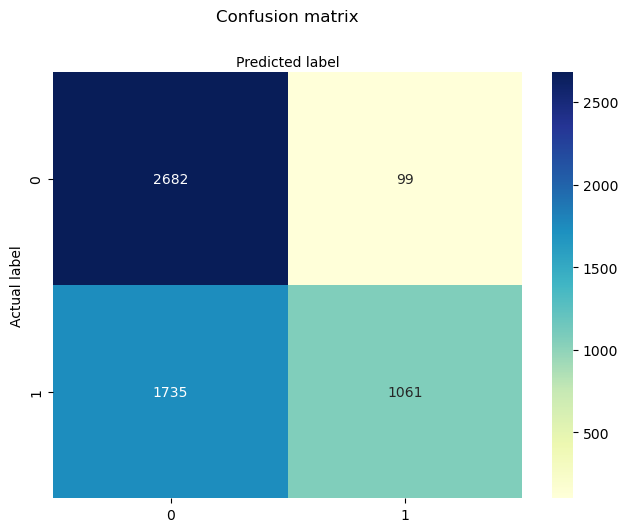

In [27]:
# import required modules
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.savefig("confusionmatrix.png")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


## ROC Curve 

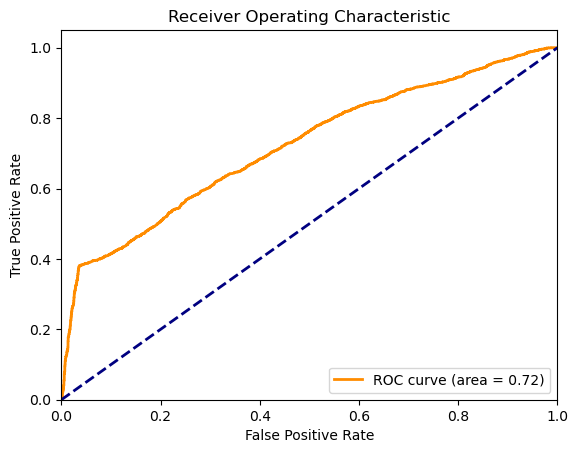

AUC: 0.7200


In [29]:
fpr,tpr,th = roc_curve(y_test,y_pred_prob)
roc_auc = roc_auc_score(y_test,y_pred_prob)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Dashed diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig("ROC_curve")
plt.show()

# Print AUC score
print(f'AUC: {roc_auc:.4f}')

## Heat map to check correlation between the features

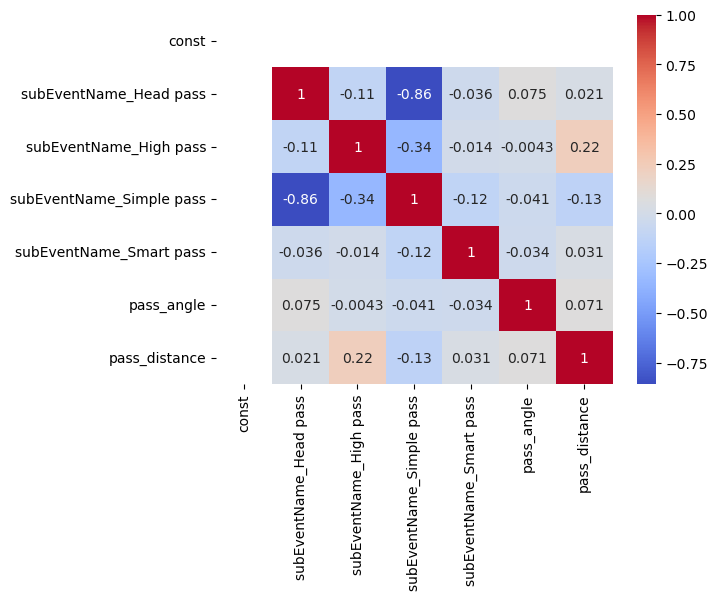

In [31]:
# Compute the correlation matrix
corr_matrix = X_train.corr()

# Plot the heatmap
#plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.savefig("corr_features.png")
plt.show()

## Fitting england dataset into trained model to predict interceptions

In [33]:
#print(test.columns
data_model = england_data_final[features]
data_model = sm.add_constant(data_model)
data_predict = result.predict(data_model)
#interceptions_predict

interceptions_predict= np.where(data_predict >= 0.5, 1, 0)

england_data_final["interceptions predicted"] = interceptions_predict
#england_data_final[england_data_final['interception' == 1]]
#england_data_final[england_data_final['interceptions predicted'] == 1]

In [34]:
england_data_final.columns

Index(['eventId', 'tags', 'playerId', 'positions', 'matchId', 'eventName',
       'teamId', 'matchPeriod', 'eventSec', 'subEventId', 'id', 'interception',
       'start_x', 'start_y', 'end_x', 'end_y', 'pass_distance', 'delta_x',
       'delta_y', 'pass_angle', 'interception_Zones', 'subEventName_Cross',
       'subEventName_Head pass', 'subEventName_High pass',
       'subEventName_Simple pass', 'subEventName_Smart pass',
       'interceptions predicted'],
      dtype='object')

## Filtering with team Manchester city

In [36]:
Manchaster_data = england_data_final[england_data_final["teamId"] == 1625] 
summary = Manchaster_data[["playerId", "interceptions predicted"]].groupby(["playerId"]).sum().reset_index()
summary


,playerId,interceptions predicted
0,3662,0
1,8277,71
2,8307,44
3,8317,34
4,8324,4
5,8325,6
6,8464,20
7,9380,29
8,11066,15
9,14808,26


## calculating interception per 90 mins based on predicted interceptions from the model and then finding the top players

In [38]:
summary_england = Manchaster_data[["playerId", "interceptions predicted"]].groupby(["playerId"]).sum().reset_index()
#add player name
path = 'players.json'
player_df = pd.read_json(path, encoding='unicode-escape')
player_df.rename(columns = {'wyId':'playerId'}, inplace=True)
player_df["role"] = player_df.apply(lambda x: x.role["name"], axis = 1)
to_merge = player_df[['playerId', 'shortName', 'role']]
summary_england = summary_england.merge(to_merge, how = "left", on = ["playerId"])

#loading the minutes data of England
path = "minutes_england.json"
with open(path) as f:
    minutes_per_game = json.load(f)
minutes_per_game = pd.DataFrame(minutes_per_game)
minutes_per_game = minutes_per_game[minutes_per_game["teamId"] == 1625]
minutes = minutes_per_game.groupby(["playerId"]).minutesPlayed.sum().reset_index()

summary_england_final = minutes.merge(summary_england, how = "left", on = ["playerId"])
summary_england_final = summary_england_final.loc[summary_england_final["minutesPlayed"] > 900]
summary_england_final["interception_per_90mins"] =  round((summary_england_final["interceptions predicted"]*90/summary_england_final["minutesPlayed"]),2)
summary_england_final = summary_england_final[["shortName","interceptions predicted","interception_per_90mins","role"]].sort_values(by='interception_per_90mins', ascending=False).head(10)
summary_england_final


,shortName,interceptions predicted,interception_per_90mins,role
14,N. Otamendi,103,2.99,Defender
2,V. Kompany,44,2.72,Defender
16,Fernandinho,88,2.63,Midfielder
1,K. Walker,71,2.20,Defender
7,J. Stones,29,1.92,Defender
9,İ. Gündoğan,26,1.47,Midfielder
20,Bernardo Silva,25,1.39,Midfielder
12,Danilo,20,1.26,Defender
3,David Silva,34,1.21,Midfielder
11,K. De Bruyne,37,1.04,Midfielder


## Loading spain dataset

In [40]:
spain_data = pd.read_json('events_Spain.json')
spain_data
#spain_data.columns

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],3542,"[{'y': 61, 'x': 37}, {'y': 50, 'x': 50}]",2565548,Pass,682,1H,2.994582,85,180864419
1,8,Simple pass,[{'id': 1801}],274435,"[{'y': 50, 'x': 50}, {'y': 30, 'x': 45}]",2565548,Pass,682,1H,3.137020,85,180864418
2,8,Simple pass,[{'id': 1801}],364860,"[{'y': 30, 'x': 45}, {'y': 12, 'x': 38}]",2565548,Pass,682,1H,6.709668,85,180864420
3,8,Simple pass,[{'id': 1801}],3534,"[{'y': 12, 'x': 38}, {'y': 69, 'x': 32}]",2565548,Pass,682,1H,8.805497,85,180864421
4,8,Simple pass,[{'id': 1801}],3695,"[{'y': 69, 'x': 32}, {'y': 37, 'x': 31}]",2565548,Pass,682,1H,14.047492,85,180864422
...,...,...,...,...,...,...,...,...,...,...,...,...
628654,8,Simple pass,[{'id': 1801}],20623,"[{'y': 25, 'x': 66}, {'y': 2, 'x': 88}]",2565927,Pass,682,2H,2939.077491,85,253302671
628655,7,Acceleration,[{'id': 1801}],122832,"[{'y': 2, 'x': 88}, {'y': 21, 'x': 97}]",2565927,Others on the ball,682,2H,2940.515560,70,253302673
628656,8,Cross,"[{'id': 401}, {'id': 1802}]",122832,"[{'y': 21, 'x': 97}, {'y': 26, 'x': 92}]",2565927,Pass,682,2H,2942.098761,80,253302674
628657,8,Simple pass,[{'id': 1801}],40756,"[{'y': 74, 'x': 8}, {'y': 56, 'x': 9}]",2565927,Pass,675,2H,2943.089232,85,253302698


## Dropping unwanted subeventName's and evenName's

In [42]:
interrupt_spain = spain_data.loc[spain_data['eventName'] == 'Interruption']
spain_data = spain_data.drop(interrupt_spain.index)

#filter out non-accurate duels
lost_duels = spain_data.loc[spain_data["eventName"] == "Duel"]
spain_data = spain_data.drop(lost_duels.index)

#filtering the subevents not needed
sevents_dropped = spain_data.loc[spain_data["subEventName"].isin(["Ball out of the feild","Save attempt","Goalkeeper leaving line","Reflexes","Launch","Hand pass"])]
spain_data_new = spain_data.drop(sevents_dropped.index)

#new_data = england_data.drop(sevents_dropped.index)
spain_data_new


,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],3542,"[{'y': 61, 'x': 37}, {'y': 50, 'x': 50}]",2565548,Pass,682,1H,2.994582,85,180864419
1,8,Simple pass,[{'id': 1801}],274435,"[{'y': 50, 'x': 50}, {'y': 30, 'x': 45}]",2565548,Pass,682,1H,3.137020,85,180864418
2,8,Simple pass,[{'id': 1801}],364860,"[{'y': 30, 'x': 45}, {'y': 12, 'x': 38}]",2565548,Pass,682,1H,6.709668,85,180864420
3,8,Simple pass,[{'id': 1801}],3534,"[{'y': 12, 'x': 38}, {'y': 69, 'x': 32}]",2565548,Pass,682,1H,8.805497,85,180864421
4,8,Simple pass,[{'id': 1801}],3695,"[{'y': 69, 'x': 32}, {'y': 37, 'x': 31}]",2565548,Pass,682,1H,14.047492,85,180864422
...,...,...,...,...,...,...,...,...,...,...,...,...
628654,8,Simple pass,[{'id': 1801}],20623,"[{'y': 25, 'x': 66}, {'y': 2, 'x': 88}]",2565927,Pass,682,2H,2939.077491,85,253302671
628655,7,Acceleration,[{'id': 1801}],122832,"[{'y': 2, 'x': 88}, {'y': 21, 'x': 97}]",2565927,Others on the ball,682,2H,2940.515560,70,253302673
628656,8,Cross,"[{'id': 401}, {'id': 1802}]",122832,"[{'y': 21, 'x': 97}, {'y': 26, 'x': 92}]",2565927,Pass,682,2H,2942.098761,80,253302674
628657,8,Simple pass,[{'id': 1801}],40756,"[{'y': 74, 'x': 8}, {'y': 56, 'x': 9}]",2565927,Pass,675,2H,2943.089232,85,253302698


## Filtering the dataset by pass and tag id accurate

In [44]:
spain_data_update = spain_data_new.loc[spain_data_new["eventName"] == "Pass"]
spain_data_filtered = spain_data_update.loc[spain_data_update.apply(lambda row : {'id' : 1801} in row.tags,axis=1)]
spain_data_filtered

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],3542,"[{'y': 61, 'x': 37}, {'y': 50, 'x': 50}]",2565548,Pass,682,1H,2.994582,85,180864419
1,8,Simple pass,[{'id': 1801}],274435,"[{'y': 50, 'x': 50}, {'y': 30, 'x': 45}]",2565548,Pass,682,1H,3.137020,85,180864418
2,8,Simple pass,[{'id': 1801}],364860,"[{'y': 30, 'x': 45}, {'y': 12, 'x': 38}]",2565548,Pass,682,1H,6.709668,85,180864420
3,8,Simple pass,[{'id': 1801}],3534,"[{'y': 12, 'x': 38}, {'y': 69, 'x': 32}]",2565548,Pass,682,1H,8.805497,85,180864421
4,8,Simple pass,[{'id': 1801}],3695,"[{'y': 69, 'x': 32}, {'y': 37, 'x': 31}]",2565548,Pass,682,1H,14.047492,85,180864422
...,...,...,...,...,...,...,...,...,...,...,...,...
628640,8,Simple pass,[{'id': 1801}],3695,"[{'y': 16, 'x': 7}, {'y': 6, 'x': 27}]",2565927,Pass,682,2H,2874.769542,85,253302650
628641,8,Simple pass,[{'id': 1801}],286994,"[{'y': 6, 'x': 27}, {'y': 4, 'x': 40}]",2565927,Pass,682,2H,2876.959208,85,253302651
628652,8,Simple pass,[{'id': 1801}],3695,"[{'y': 34, 'x': 36}, {'y': 52, 'x': 45}]",2565927,Pass,682,2H,2931.782904,85,253302665
628654,8,Simple pass,[{'id': 1801}],20623,"[{'y': 25, 'x': 66}, {'y': 2, 'x': 88}]",2565927,Pass,682,2H,2939.077491,85,253302671


## Filtering the dataset with interception tag and adding column to check if intercepted or not

In [46]:
spain_data_filtered["interception"] = spain_data_filtered['tags'].apply(lambda x : 1 if {'id' : 1401} in x else 0)
print(spain_data_filtered["subEventName"].unique())
spain_data_filtered.head(50) 

['Simple pass' 'Smart pass' 'Head pass' 'Cross' 'High pass']


,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,interception
0,8,Simple pass,[{'id': 1801}],3542,"[{'y': 61, 'x': 37}, {'y': 50, 'x': 50}]",2565548,Pass,682,1H,2.994582,85,180864419,0
1,8,Simple pass,[{'id': 1801}],274435,"[{'y': 50, 'x': 50}, {'y': 30, 'x': 45}]",2565548,Pass,682,1H,3.137020,85,180864418,0
2,8,Simple pass,[{'id': 1801}],364860,"[{'y': 30, 'x': 45}, {'y': 12, 'x': 38}]",2565548,Pass,682,1H,6.709668,85,180864420,0
3,8,Simple pass,[{'id': 1801}],3534,"[{'y': 12, 'x': 38}, {'y': 69, 'x': 32}]",2565548,Pass,682,1H,8.805497,85,180864421,0
4,8,Simple pass,[{'id': 1801}],3695,"[{'y': 69, 'x': 32}, {'y': 37, 'x': 31}]",2565548,Pass,682,1H,14.047492,85,180864422,0
5,8,Simple pass,[{'id': 1801}],3277,"[{'y': 37, 'x': 31}, {'y': 83, 'x': 37}]",2565548,Pass,682,1H,18.480831,85,180864423,0
6,8,Simple pass,[{'id': 1801}],3695,"[{'y': 83, 'x': 37}, {'y': 53, 'x': 13}]",2565548,Pass,682,1H,23.978291,85,180864424,0
7,8,Simple pass,[{'id': 1801}],3486,"[{'y': 53, 'x': 13}, {'y': 41, 'x': 33}]",2565548,Pass,682,1H,28.831334,85,180864425,0
8,8,Simple pass,[{'id': 1801}],3277,"[{'y': 41, 'x': 33}, {'y': 79, 'x': 33}]",2565548,Pass,682,1H,30.844379,85,180864426,0
9,8,Simple pass,[{'id': 1801}],3695,"[{'y': 79, 'x': 33}, {'y': 98, 'x': 54}]",2565548,Pass,682,1H,34.267339,85,180864427,0


## Calculating Pass distance

In [48]:
spain_data_filtered["start_x"] = spain_data_filtered['positions'].apply(lambda row : row[0]['x']*105/100)
spain_data_filtered["start_y"] = spain_data_filtered['positions'].apply(lambda row : row[0]['x']*68/100)
spain_data_filtered["end_x"] = spain_data_filtered['positions'].apply(lambda row : row[1]['x']*105/100)
spain_data_filtered["end_y"] = spain_data_filtered['positions'].apply(lambda row : row[1]['y']*68/100)
spain_data_filtered["pass_distance"] = np.sqrt((spain_data_filtered["end_x"] - spain_data_filtered["start_x"]) ** 2 + (spain_data_filtered["end_y"] - spain_data_filtered["start_y"]) ** 2)
england_data_filtered
#england_data_filtered.loc[england_data_filtered["start_x"] == 0]


,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,...,interception,start_x,start_y,end_x,end_y,pass_distance,delta_x,delta_y,pass_angle,interception_Zones
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,...,0,51.45,33.32,32.55,53.04,27.314619,-18.90,19.72,2.334965,no interception
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,...,0,32.55,21.08,53.55,51.00,36.554157,21.00,29.92,0.958815,no interception
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,...,0,53.55,34.68,36.75,48.28,21.614810,-16.80,13.60,2.461071,no interception
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,...,0,36.75,23.80,43.05,64.60,41.283532,6.30,40.80,1.417595,no interception
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,...,0,43.05,27.88,75.60,59.84,45.617366,32.55,31.96,0.776253,no interception
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643133,8,Simple pass,[{'id': 1801}],37725,"[{'y': 56, 'x': 57}, {'y': 63, 'x': 65}]",2500098,Pass,1633,2H,2758.973892,...,0,59.85,38.76,68.25,42.84,9.338437,8.40,4.08,0.452154,no interception
643134,8,Simple pass,[{'id': 1801}],8313,"[{'y': 63, 'x': 65}, {'y': 96, 'x': 61}]",2500098,Pass,1633,2H,2760.286946,...,0,68.25,44.20,64.05,65.28,21.494334,-4.20,21.08,1.767462,no interception
643135,8,Simple pass,[{'id': 1801}],379209,"[{'y': 96, 'x': 61}, {'y': 85, 'x': 40}]",2500098,Pass,1633,2H,2763.698599,...,0,64.05,41.48,42.00,57.80,27.432552,-22.05,16.32,2.504434,no interception
643141,8,Simple pass,[{'id': 1801}],8561,"[{'y': 70, 'x': 59}, {'y': 89, 'x': 53}]",2500098,Pass,1633,2H,2783.137836,...,0,61.95,40.12,55.65,60.52,21.350644,-6.30,20.40,1.870328,no interception


## Calculating Pass Angle

In [50]:
spain_data_filtered["delta_x"] = spain_data_filtered["end_x"] - spain_data_filtered["start_x"]
spain_data_filtered["delta_y"] = spain_data_filtered["end_y"] - spain_data_filtered["start_y"]
spain_data_filtered["pass_angle"] = np.arctan2(spain_data_filtered["delta_y"],spain_data_filtered["delta_x"])
spain_data_filtered

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,...,id,interception,start_x,start_y,end_x,end_y,pass_distance,delta_x,delta_y,pass_angle
0,8,Simple pass,[{'id': 1801}],3542,"[{'y': 61, 'x': 37}, {'y': 50, 'x': 50}]",2565548,Pass,682,1H,2.994582,...,180864419,0,38.85,25.16,52.50,34.00,16.262475,13.65,8.84,0.574700
1,8,Simple pass,[{'id': 1801}],274435,"[{'y': 50, 'x': 50}, {'y': 30, 'x': 45}]",2565548,Pass,682,1H,3.137020,...,180864418,0,52.50,34.00,47.25,20.40,14.578151,-5.25,-13.60,-1.939201
2,8,Simple pass,[{'id': 1801}],364860,"[{'y': 30, 'x': 45}, {'y': 12, 'x': 38}]",2565548,Pass,682,1H,6.709668,...,180864420,0,47.25,30.60,39.90,8.16,23.613049,-7.35,-22.44,-1.887324
3,8,Simple pass,[{'id': 1801}],3534,"[{'y': 12, 'x': 38}, {'y': 69, 'x': 32}]",2565548,Pass,682,1H,8.805497,...,180864421,0,39.90,25.84,33.60,46.92,22.001282,-6.30,21.08,1.861208
4,8,Simple pass,[{'id': 1801}],3695,"[{'y': 69, 'x': 32}, {'y': 37, 'x': 31}]",2565548,Pass,682,1H,14.047492,...,180864422,0,33.60,21.76,32.55,25.16,3.558441,-1.05,3.40,1.870328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628640,8,Simple pass,[{'id': 1801}],3695,"[{'y': 16, 'x': 7}, {'y': 6, 'x': 27}]",2565927,Pass,682,2H,2874.769542,...,253302650,0,7.35,4.76,28.35,4.08,21.011007,21.00,-0.68,-0.032370
628641,8,Simple pass,[{'id': 1801}],286994,"[{'y': 6, 'x': 27}, {'y': 4, 'x': 40}]",2565927,Pass,682,2H,2876.959208,...,253302651,0,28.35,18.36,42.00,2.72,20.758904,13.65,-15.64,-0.853235
628652,8,Simple pass,[{'id': 1801}],3695,"[{'y': 34, 'x': 36}, {'y': 52, 'x': 45}]",2565927,Pass,682,2H,2931.782904,...,253302665,0,37.80,24.48,47.25,35.36,14.410999,9.45,10.88,0.855622
628654,8,Simple pass,[{'id': 1801}],20623,"[{'y': 25, 'x': 66}, {'y': 2, 'x': 88}]",2565927,Pass,682,2H,2939.077491,...,253302671,0,69.30,44.88,92.40,1.36,49.270685,23.10,-43.52,-1.082821


## Calculating interception Zones

In [52]:

# Apply the function to the 'start_x' column
spain_data_filtered["interception_Zones"] = spain_data_filtered.apply(lambda x: zones(x.interception , x.start_x) , axis=1)

spain_data_filtered
#england_data_filtered.loc[england_data_filtered["interception_Zones"] == "defensive third"]
                                              
        

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,...,interception,start_x,start_y,end_x,end_y,pass_distance,delta_x,delta_y,pass_angle,interception_Zones
0,8,Simple pass,[{'id': 1801}],3542,"[{'y': 61, 'x': 37}, {'y': 50, 'x': 50}]",2565548,Pass,682,1H,2.994582,...,0,38.85,25.16,52.50,34.00,16.262475,13.65,8.84,0.574700,no interception
1,8,Simple pass,[{'id': 1801}],274435,"[{'y': 50, 'x': 50}, {'y': 30, 'x': 45}]",2565548,Pass,682,1H,3.137020,...,0,52.50,34.00,47.25,20.40,14.578151,-5.25,-13.60,-1.939201,no interception
2,8,Simple pass,[{'id': 1801}],364860,"[{'y': 30, 'x': 45}, {'y': 12, 'x': 38}]",2565548,Pass,682,1H,6.709668,...,0,47.25,30.60,39.90,8.16,23.613049,-7.35,-22.44,-1.887324,no interception
3,8,Simple pass,[{'id': 1801}],3534,"[{'y': 12, 'x': 38}, {'y': 69, 'x': 32}]",2565548,Pass,682,1H,8.805497,...,0,39.90,25.84,33.60,46.92,22.001282,-6.30,21.08,1.861208,no interception
4,8,Simple pass,[{'id': 1801}],3695,"[{'y': 69, 'x': 32}, {'y': 37, 'x': 31}]",2565548,Pass,682,1H,14.047492,...,0,33.60,21.76,32.55,25.16,3.558441,-1.05,3.40,1.870328,no interception
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628640,8,Simple pass,[{'id': 1801}],3695,"[{'y': 16, 'x': 7}, {'y': 6, 'x': 27}]",2565927,Pass,682,2H,2874.769542,...,0,7.35,4.76,28.35,4.08,21.011007,21.00,-0.68,-0.032370,no interception
628641,8,Simple pass,[{'id': 1801}],286994,"[{'y': 6, 'x': 27}, {'y': 4, 'x': 40}]",2565927,Pass,682,2H,2876.959208,...,0,28.35,18.36,42.00,2.72,20.758904,13.65,-15.64,-0.853235,no interception
628652,8,Simple pass,[{'id': 1801}],3695,"[{'y': 34, 'x': 36}, {'y': 52, 'x': 45}]",2565927,Pass,682,2H,2931.782904,...,0,37.80,24.48,47.25,35.36,14.410999,9.45,10.88,0.855622,no interception
628654,8,Simple pass,[{'id': 1801}],20623,"[{'y': 25, 'x': 66}, {'y': 2, 'x': 88}]",2565927,Pass,682,2H,2939.077491,...,0,69.30,44.88,92.40,1.36,49.270685,23.10,-43.52,-1.082821,no interception


## Converting passes to categorical values 0's and 1's

In [54]:
spain_data_final = pd.get_dummies(spain_data_filtered,columns=['subEventName'],dtype=int)
spain_data_final.columns

Index(['eventId', 'tags', 'playerId', 'positions', 'matchId', 'eventName',
       'teamId', 'matchPeriod', 'eventSec', 'subEventId', 'id', 'interception',
       'start_x', 'start_y', 'end_x', 'end_y', 'pass_distance', 'delta_x',
       'delta_y', 'pass_angle', 'interception_Zones', 'subEventName_Cross',
       'subEventName_Head pass', 'subEventName_High pass',
       'subEventName_Simple pass', 'subEventName_Smart pass'],
      dtype='object')

## Using the model to fit the spain dataset to predict interceptions

In [56]:
features = ['subEventName_Head pass','subEventName_High pass','subEventName_Simple pass', 'subEventName_Smart pass','pass_angle','pass_distance']
X_spain = spain_data_final[features]
X_spain =sm.add_constant(X_spain)

y_pred_spain = result.predict(X_spain)

interceptions_pred_spain = np.where(y_pred_spain >= 0.5, 1, 0)


spain_data_final["interceptions_predicted"] = interceptions_pred_spain
spain_data_final



,eventId,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,...,delta_x,delta_y,pass_angle,interception_Zones,subEventName_Cross,subEventName_Head pass,subEventName_High pass,subEventName_Simple pass,subEventName_Smart pass,interceptions_predicted
0,8,[{'id': 1801}],3542,"[{'y': 61, 'x': 37}, {'y': 50, 'x': 50}]",2565548,Pass,682,1H,2.994582,85,...,13.65,8.84,0.574700,no interception,0,0,0,1,0,0
1,8,[{'id': 1801}],274435,"[{'y': 50, 'x': 50}, {'y': 30, 'x': 45}]",2565548,Pass,682,1H,3.137020,85,...,-5.25,-13.60,-1.939201,no interception,0,0,0,1,0,0
2,8,[{'id': 1801}],364860,"[{'y': 30, 'x': 45}, {'y': 12, 'x': 38}]",2565548,Pass,682,1H,6.709668,85,...,-7.35,-22.44,-1.887324,no interception,0,0,0,1,0,0
3,8,[{'id': 1801}],3534,"[{'y': 12, 'x': 38}, {'y': 69, 'x': 32}]",2565548,Pass,682,1H,8.805497,85,...,-6.30,21.08,1.861208,no interception,0,0,0,1,0,0
4,8,[{'id': 1801}],3695,"[{'y': 69, 'x': 32}, {'y': 37, 'x': 31}]",2565548,Pass,682,1H,14.047492,85,...,-1.05,3.40,1.870328,no interception,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628640,8,[{'id': 1801}],3695,"[{'y': 16, 'x': 7}, {'y': 6, 'x': 27}]",2565927,Pass,682,2H,2874.769542,85,...,21.00,-0.68,-0.032370,no interception,0,0,0,1,0,0
628641,8,[{'id': 1801}],286994,"[{'y': 6, 'x': 27}, {'y': 4, 'x': 40}]",2565927,Pass,682,2H,2876.959208,85,...,13.65,-15.64,-0.853235,no interception,0,0,0,1,0,0
628652,8,[{'id': 1801}],3695,"[{'y': 34, 'x': 36}, {'y': 52, 'x': 45}]",2565927,Pass,682,2H,2931.782904,85,...,9.45,10.88,0.855622,no interception,0,0,0,1,0,0
628654,8,[{'id': 1801}],20623,"[{'y': 25, 'x': 66}, {'y': 2, 'x': 88}]",2565927,Pass,682,2H,2939.077491,85,...,23.10,-43.52,-1.082821,no interception,0,0,0,1,0,0


## calculating interception per 90 mins based on predicted interceptions from the model and then finding the top players

In [58]:
summary_spain = spain_data_final[["playerId", "interceptions_predicted"]].groupby(["playerId"]).sum().reset_index()
summary_spain["interceptions_predicted"] = summary_spain["interceptions_predicted"].astype(int) 

#add player name
path = 'players.json'
player_df = pd.read_json(path, encoding='unicode-escape')
player_df.rename(columns = {'wyId':'playerId'}, inplace=True)
player_df["role"] = player_df.apply(lambda x: x.role["name"], axis = 1)
to_merge = player_df[['playerId', 'shortName', 'role',"birthDate"]] 
summary_spain_update = summary_spain.merge(to_merge, how = "left", on = ["playerId"])
#summary_england[summary_england["interceptions_predicted"]==1]
#print(summary_spain_update)


#loading spain minutes data#
path = "minutes_Spain.json"
with open(path) as f:
    minutes_per_game = json.load(f)
minutes_per_game = pd.DataFrame(minutes_per_game)
minutes = minutes_per_game.groupby(["playerId"]).minutesPlayed.sum().reset_index()

#minutes

summary_spain_new= minutes.merge(summary_spain_update, how = "left", on = ["playerId"])
#summary_spain_new = summary_spain_new.fillna(0)
summary_spain_new = summary_spain_new.loc[summary_spain_new["minutesPlayed"]>=900]
summary_spain_new["year"] = pd.to_datetime(summary_spain_new['birthDate']).dt.year
summary_spain_new['age'] = 2018 - summary_spain_new['year']
summary_spain_new["interception_per_90mins"] =  round((summary_spain_new["interceptions_predicted"]*90/summary_spain_new["minutesPlayed"]),2)
summary_spain_new[["shortName","interceptions_predicted","interception_per_90mins","role",'playerId']].sort_values(by='interception_per_90mins', ascending=False).head(10)



,shortName,interceptions_predicted,interception_per_90mins,role,playerId
162,Lombán,48.0,4.17,Defender,4180
200,Arbilla,110.0,3.96,Defender,4805
288,P. Baysse,56.0,3.92,Defender,26332
260,S. Kjær,68.0,3.75,Defender,20433
215,Dani García,114.0,3.58,Midfielder,5542
142,G. Cabral,76.0,3.48,Defender,3916
213,Luis Hernández,125.0,3.35,Defender,5472
377,G. Escalante,57.0,3.15,Midfielder,212644
50,Iturraspe,69.0,3.14,Midfielder,3414
225,Bustinza,59.0,3.14,Defender,6365


## Player recommendation of age<25

In [60]:
summary_spain = spain_data_final[["playerId", "interceptions_predicted","interception"]].groupby(["playerId"]).sum().reset_index()
summary_spain["interceptions_predicted"] = summary_spain["interceptions_predicted"].astype(int) 

#add player name
path = 'players.json'
player_df = pd.read_json(path, encoding='unicode-escape')
player_df.rename(columns = {'wyId':'playerId'}, inplace=True)
player_df["role"] = player_df.apply(lambda x: x.role["name"], axis = 1)
to_merge = player_df[['playerId', 'shortName', 'role',"birthDate"]] 
summary_spain_update = summary_spain.merge(to_merge, how = "left", on = ["playerId"])
#summary_england[summary_england["interceptions_predicted"]==1]
#print(summary_spain_update)


#loading spain minutes data#
path = "minutes_Spain.json"
with open(path) as f:
    minutes_per_game = json.load(f)
minutes_per_game = pd.DataFrame(minutes_per_game)
minutes = minutes_per_game.groupby(["playerId"]).minutesPlayed.sum().reset_index()

#minutes

summary_spain_new= minutes.merge(summary_spain_update, how = "left", on = ["playerId"])
#summary_spain_new = summary_spain_new.fillna(0)
summary_spain_new = summary_spain_new.loc[summary_spain_new["minutesPlayed"] >= 900]
summary_spain_new["year"] = pd.to_datetime(summary_spain_new['birthDate']).dt.year
summary_spain_new['age'] = 2018 - summary_spain_new['year']
summary_spain_agewise = summary_spain_new[summary_spain_new['age']<25]
summary_spain_agewise["interception_per_90mins_predicted"] =  round((summary_spain_agewise["interceptions_predicted"]*90/summary_spain_agewise["minutesPlayed"]),2)
summary_spain_agewise["interception_per_90mins_actual"] =  round((summary_spain_agewise["interception"]*90/summary_spain_agewise["minutesPlayed"]),2)
summary_spain_agewise[["shortName","interceptions_predicted","interception","interception_per_90mins_predicted","interception_per_90mins_actual","role",'playerId','age']].sort_values(by='interception_per_90mins_predicted', ascending=False).head(10)



,shortName,interceptions_predicted,interception,interception_per_90mins_predicted,interception_per_90mins_actual,role,playerId,age
359,A. Laporte,56.0,29.0,2.84,1.47,Defender,134502,24
420,J. Lerma,70.0,42.0,2.84,1.70,Midfielder,255738,24
191,Saúl,97.0,49.0,2.68,1.35,Midfielder,4488,24
444,Aritz Elustondo,49.0,34.0,2.68,1.86,Defender,278288,24
492,Unai Núñez,87.0,61.0,2.57,1.80,Defender,344068,21
385,Rubén Duarte,61.0,48.0,2.48,1.95,Defender,225022,23
405,Diego González,38.0,17.0,2.32,1.04,Defender,247169,23
450,Mario Hermoso,51.0,41.0,2.30,1.85,Defender,279533,23
507,Rodri,85.0,74.0,2.29,1.99,Midfielder,364860,22
521,Zubeldía,41.0,26.0,2.25,1.43,Midfielder,395114,21


## Additional analysis of interception of players zonewise (England dataset is considered with actual interception)

In [62]:
england_zones = pd.get_dummies(england_data_final,columns=['interception_Zones'],dtype=int)
england_zones = england_zones.drop("interception_Zones_no interception",axis=1)
#england_zones
zone_analysis = england_zones[["playerId", "interception",'interception_Zones_defensive third','interception_Zones_offensive third','interception_Zones_middle third']].groupby(["playerId"]).sum().reset_index()
zone_analysis

path = 'players.json'
player_analysis = pd.read_json(path, encoding='unicode-escape')
player_analysis.rename(columns = {'wyId':'playerId'}, inplace=True)
player_analysis["role"] = player_analysis.apply(lambda x: x.role["name"], axis = 1)
player_analysis

players_data = player_df[['playerId', 'shortName', 'role']]
player_details = zone_analysis.merge(players_data,how = "left" , on = ['playerId'])
player_details

path = "minutes_england.json"
with open(path) as f:
    minutes_per_game_england = json.load(f)
minutes_per_game_england = pd.DataFrame(minutes_per_game_england)
minutes_per_game_england = minutes_per_game_england[minutes_per_game_england["teamId"] == 1625]
minutes_england = minutes_per_game_england.groupby(["playerId"]).minutesPlayed.sum().reset_index()

minutes_england

summary_england_interception = minutes_england.merge(player_details, how = "left", on = ["playerId"])

summary_england_interception = summary_england_interception.loc[summary_england_interception["minutesPlayed"] >= 900]
summary_england_interception


summary_england_interception["interception per 90 min"] = round((summary_england_interception["interception"]*90/summary_england_interception["minutesPlayed"]),2)
summary_england_interception["interception per 90 defensive"] = round((summary_england_interception["interception_Zones_defensive third"]*90/summary_england_interception["minutesPlayed"]),2)
summary_england_interception["interception per 90 middle"] = round((summary_england_interception["interception_Zones_middle third"]*90/summary_england_interception["minutesPlayed"]),2)
summary_england_interception["interception per 90 offensive"] = round((summary_england_interception["interception_Zones_offensive third"]*90/summary_england_interception["minutesPlayed"]),2)
summary_england_interception = summary_england_interception[["shortName","interception per 90 min","interception per 90 defensive","interception per 90 offensive","interception per 90 middle","role"]].sort_values(by='interception per 90 min', ascending=False).head(10)
summary_england_interception
    
    



#england_data_offensive = england_data_filtered.loc[england_data_filtered["interception_Zones"] == "offensive third"]
    
#england_data_defensive = england_data_filtered.loc[england_data_filtered["interception_Zones"] == "defensive third"]
#england_data_middle = england_data_filtered.loc[england_data_filtered["interception_Zones"] == "middle third"]
#print(england_data_defensive,england_data_offensive,england_data_middle)

,shortName,interception per 90 min,interception per 90 defensive,interception per 90 offensive,interception per 90 middle,role
16,Fernandinho,1.85,0.75,0.15,0.96,Midfielder
2,V. Kompany,1.73,1.30,0.06,0.37,Defender
7,J. Stones,1.66,1.46,0.00,0.20,Defender
1,K. Walker,1.46,0.65,0.09,0.71,Defender
9,İ. Gündoğan,1.30,0.45,0.23,0.62,Midfielder
14,N. Otamendi,1.25,0.67,0.03,0.55,Defender
12,Danilo,1.07,0.38,0.19,0.51,Defender
6,F. Delph,1.04,0.65,0.20,0.20,Midfielder
11,K. De Bruyne,0.87,0.06,0.20,0.62,Midfielder
3,David Silva,0.68,0.14,0.21,0.32,Midfielder


## Representation of interception in different zones by top 3 players Manchester city from England dataset

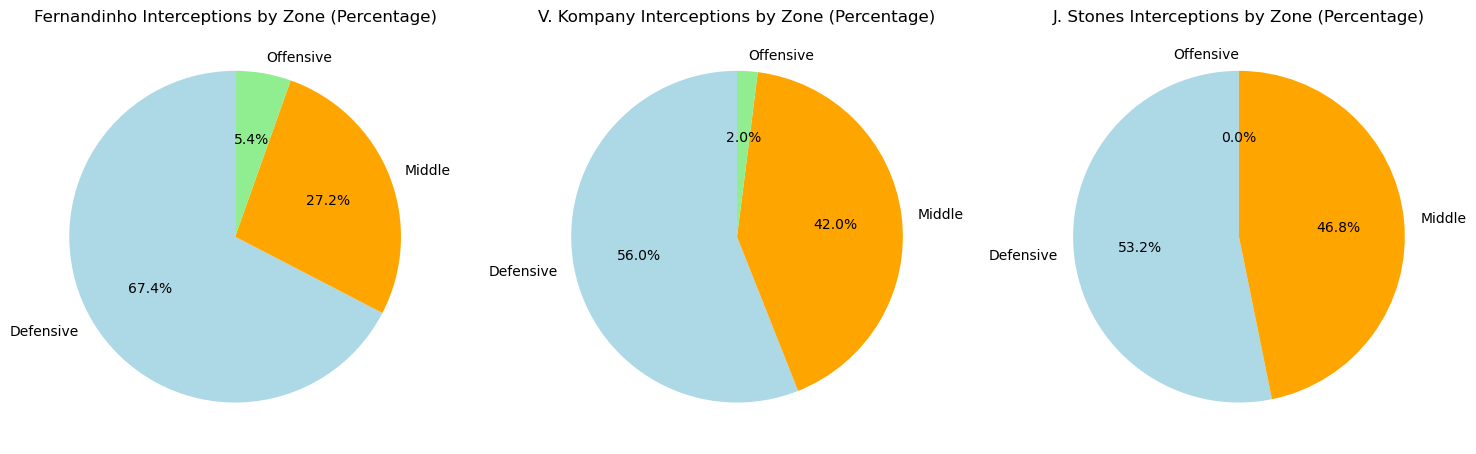

In [64]:
# Data for the players and their interceptions per zone
data = {
    'Fernandinho': [1.853821,0.747508,0.149502	],   # Defensive, Middle, Offensive
    'V. Kompany': [1.731959,1.298969,0.061856	],
    'J. Stones': [1.656848,1.458027,0.000000	]
}

zones = ['Defensive', 'Middle', 'Offensive']

# Normalize and convert to percentage
normalized_data = {}
for player, interceptions in data.items():
    total_interceptions = sum(interceptions)  # Total interceptions per player
    normalized_data[player] = [(i / total_interceptions) * 100 for i in interceptions]  # Normalize and convert to percentage

# Create subplots for the pie charts
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, (player, interceptions) in enumerate(normalized_data.items()):
    # Plot a pie chart for each player
    axs[i].pie(interceptions, labels=zones, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'orange', 'lightgreen'])
    axs[i].set_title(f"{player} Interceptions by Zone (Percentage)")

# Adjust layout
plt.tight_layout()
plt.savefig('Interception.png')
plt.show()
